# Diabetes Readmission Project: Data Exploration and Preprocessing

This project focuses on data from 130 US hospitals to predict early readmission in diabetic patients within 30 days. The project workflow includes:
1. Data Exploration and Clustering
2. Data Preprocessing and Feature Engineering
3. Algorithm Selection and Model Training
4. Result Analysis
5. Visualization
6. Web Integration


## Step 1: Importing Libraries

In [79]:
pip install dash flask plotly requests scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\orkha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [80]:
import pandas as pd
import numpy as np
import requests
from flask import Flask, request, jsonify
import dash
from dash import dcc, html
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

## Step 2 Data Loading and Initial Exploration

In this section, we load the diabetic patient dataset and perform preliminary exploratory data analysis. We begin by examining the shape of the dataset, checking for missing values, and understanding the data types present. This helps in identifying any potential issues or areas that require further cleaning.


Diabetic Data Shape: (101766, 50)
Missing Values Count:
 encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide           

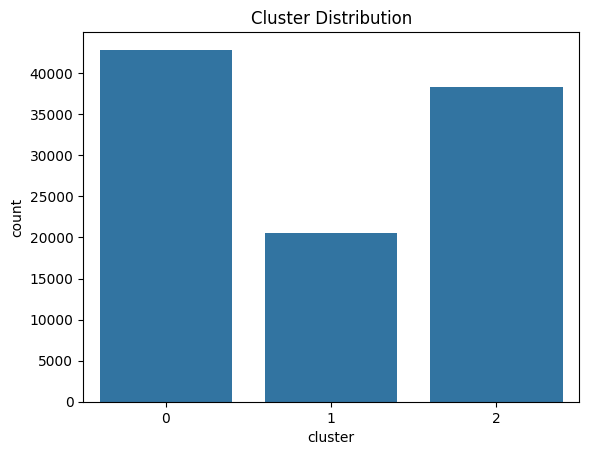

In [81]:
# Load datasets
diabetic_data = pd.read_csv('PRJ-002\diabetic_data.csv')
ids_mapping = pd.read_csv('PRJ-002\IDS_mapping.csv')

# Initial exploration
print("Diabetic Data Shape:", diabetic_data.shape)
print("Missing Values Count:\n", diabetic_data.isnull().sum())
print("Data Types:\n", diabetic_data.dtypes)

# Basic statistics
print("Basic Statistics:\n", diabetic_data.describe(include='all'))
print("******************************************************")
# Clustering analysis to identify patient segments
# Replace '?' placeholders, and perform KMeans clustering on numeric data only
diabetic_data.replace('?', np.nan, inplace=True)
numeric_data = diabetic_data.select_dtypes(include=[np.number]).fillna(0)
kmeans = KMeans(n_clusters=3, random_state=42)
diabetic_data['cluster'] = kmeans.fit_predict(numeric_data)

#Review class distribution for readmitted to assess class imbalance
print("Target Variable (readmitted) Distribution:\n", diabetic_data['readmitted'].value_counts())

# Visualize clusters
sns.countplot(data=diabetic_data, x='cluster')
plt.title("Cluster Distribution")
plt.show()


 # Summary Statistics for this step. 
 # Visualize important categorical features like gender, admission_type_id, discharge_disposition_id
 # Visualize Distribution of Numerical Features
 # Correlation Matrix and Visualize with a Heatmap

Numerical Features Summary:
        encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                   

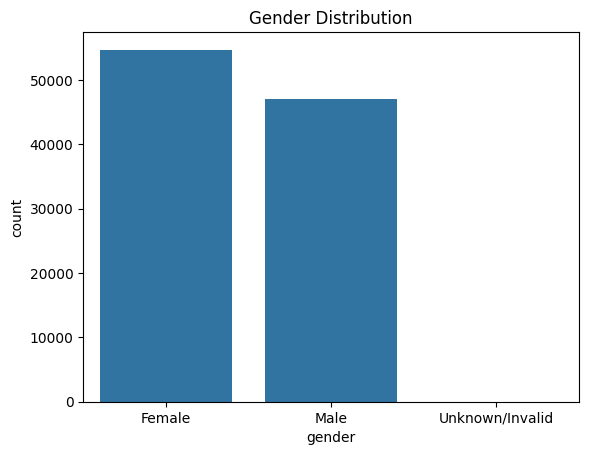

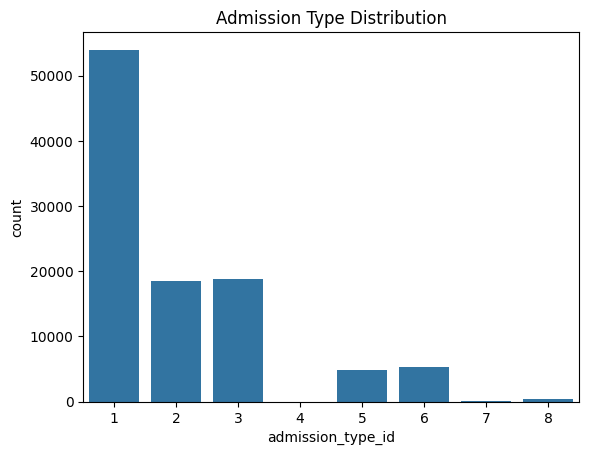

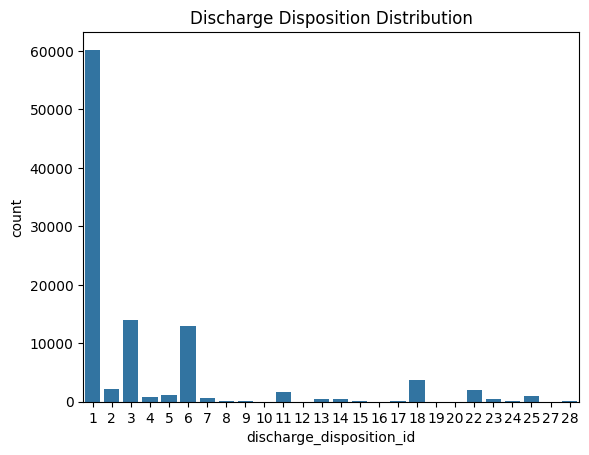

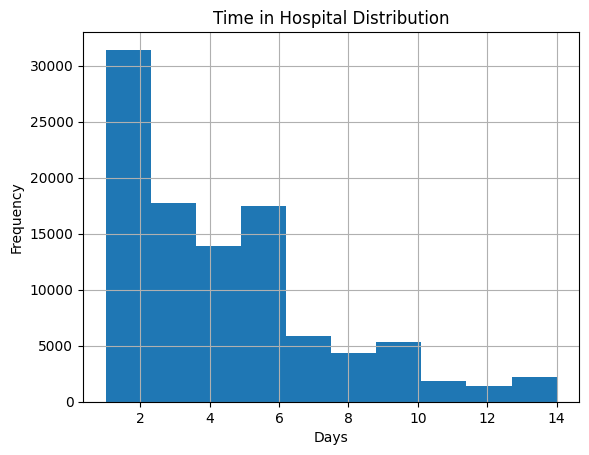

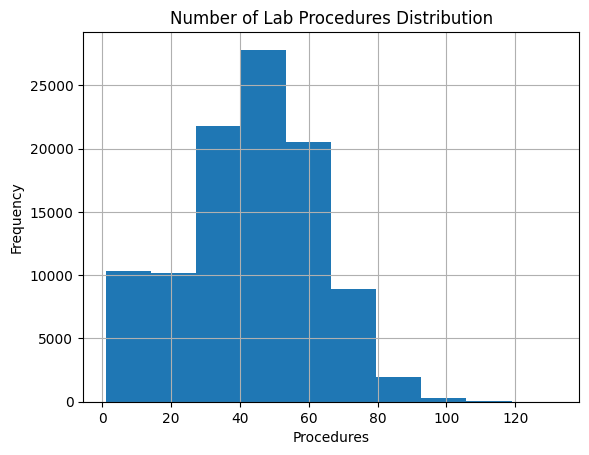

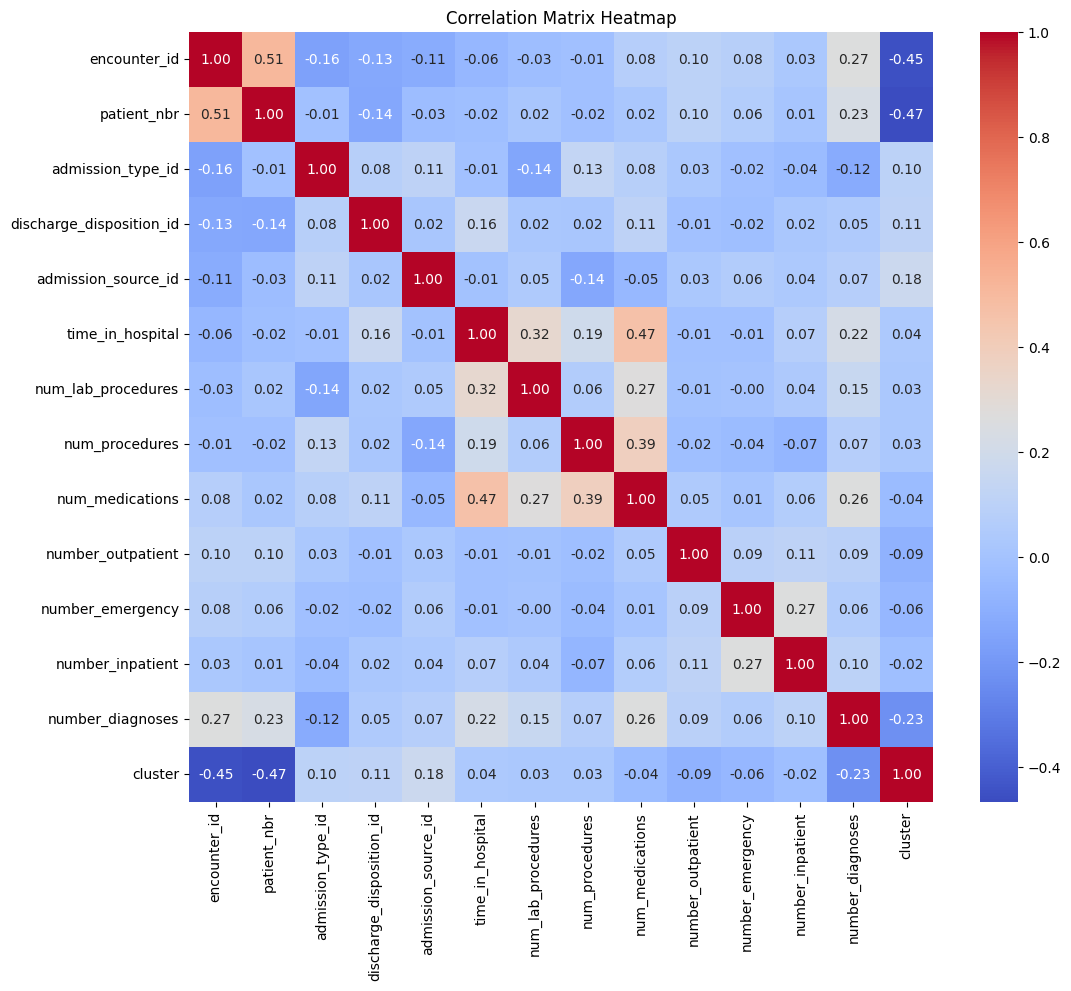

In [82]:
# Summarize numerical features only
print("Numerical Features Summary:\n", diabetic_data.describe())

# Summarize categorical features, use include='object' for object (categorical) columns
print("Categorical Features Summary:\n", diabetic_data.describe(include='object'))

sns.countplot(data=diabetic_data, x='gender')
plt.title("Gender Distribution")
plt.show()

sns.countplot(data=diabetic_data, x='admission_type_id')
plt.title("Admission Type Distribution")
plt.show()

sns.countplot(data=diabetic_data, x='discharge_disposition_id')
plt.title("Discharge Disposition Distribution")
plt.show()


diabetic_data['time_in_hospital'].hist(bins=10)
plt.title("Time in Hospital Distribution")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

diabetic_data['num_lab_procedures'].hist(bins=10)
plt.title("Number of Lab Procedures Distribution")
plt.xlabel("Procedures")
plt.ylabel("Frequency")
plt.show()


# Select only numeric columns for the correlation matrix
numeric_data = diabetic_data.select_dtypes(include=[np.number])

# Generate the correlation matrix for numeric columns only
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()



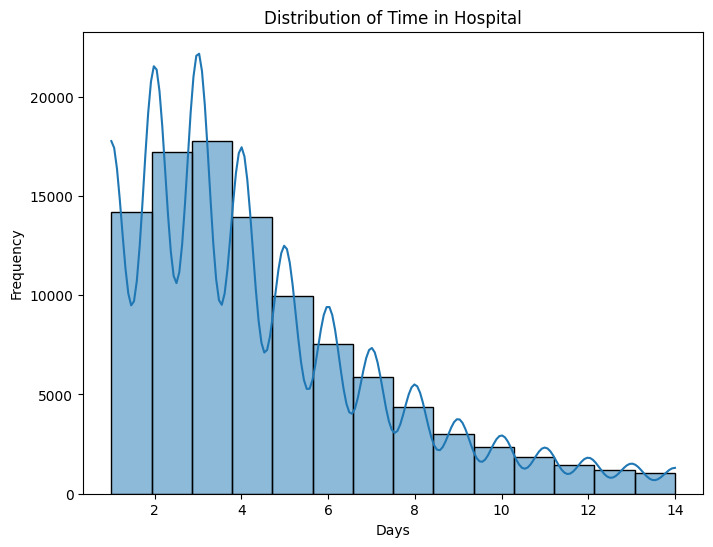

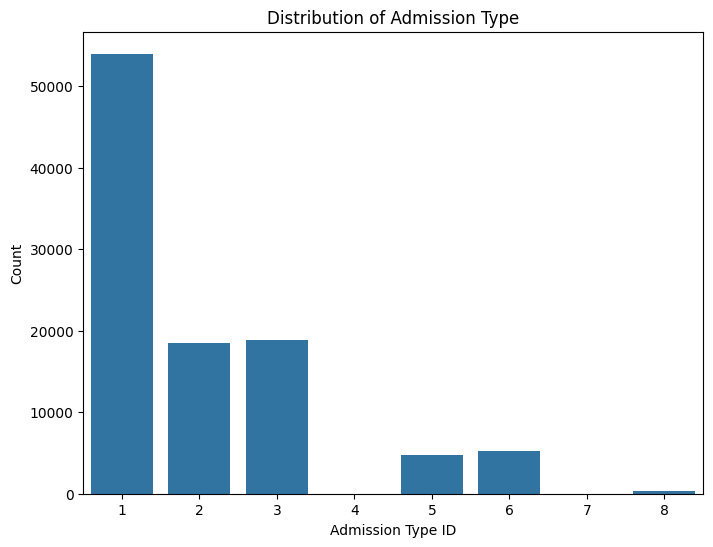

In [83]:
# Example: Distribution plot for 'time_in_hospital'
plt.figure(figsize=(8, 6))
sns.histplot(diabetic_data['time_in_hospital'], bins=14, kde=True)
plt.title("Distribution of Time in Hospital")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()



# Example: Distribution of 'admission_type_id'
plt.figure(figsize=(8, 6))
sns.countplot(data=diabetic_data, x='admission_type_id')
plt.title("Distribution of Admission Type")
plt.xlabel("Admission Type ID")
plt.ylabel("Count")
plt.show()


## Step 3 : Data Cleaning and Preprocessing
# 3.1: Data Cleaning

Handling missing values, mapping categorical IDs, encoding features, and creating additional useful features.

## Replacing Placeholders (`?`) with `NaN`

Replacing any placeholders (`?`) in the dataset with `NaN` to ensure they are accurately recognized as missing values.

In [84]:
import numpy as np

# Step 1: Replace '?' placeholders with NaN to standardize missing values
print("Replacing '?' placeholders with NaN...")
diabetic_data.replace('?', np.nan, inplace=True)

# Step 2: Checking for columns with missing values
missing_counts = diabetic_data.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]  # Filter columns with missing values only

# Print the columns with missing values
if missing_counts.empty:
    print("No missing values were found after replacement.")
else:
    print("Missing values were identified in the following columns after replacing placeholders:")
    print(missing_counts)

# Summary of missing values
print(f"\nTotal columns with missing values: {len(missing_counts)}")
print("Missing values replacement and reporting completed.\n")

# Step 3: Drop irrelevant columns with high missingness (over 90%)
columns_to_drop = ['weight', 'payer_code']
existing_columns_to_drop = [col for col in columns_to_drop if col in diabetic_data.columns]
diabetic_data.drop(columns=existing_columns_to_drop, inplace=True)
print("Dropped columns with high missingness:", existing_columns_to_drop)

# Step 4: Fill missing values in categorical columns with the most frequent (mode) value
categorical_columns_to_impute = ['race', 'medical_specialty']
for column in categorical_columns_to_impute:
    if column in diabetic_data.columns:  # Ensure column exists before imputing
        mode_value = diabetic_data[column].mode()[0]
        diabetic_data[column] = diabetic_data[column].fillna(mode_value)  # Assign back to avoid warning
        print(f"Filled missing values in '{column}' with the most frequent value: {mode_value}")

# Step 5: Impute 'max_glu_serum' and 'A1Cresult' columns with 'None' to indicate unmeasured values
for column in ['max_glu_serum', 'A1Cresult']:
    diabetic_data[column] = diabetic_data[column].fillna('None')  # Assign back to avoid warning
    print(f"Filled missing values in '{column}' with 'None'")

# Step 6: Impute missing values in diagnosis codes with the most frequent value
diagnosis_columns = ['diag_1', 'diag_2', 'diag_3']
for column in diagnosis_columns:
    if column in diabetic_data.columns:
        mode_value = diabetic_data[column].mode()[0]
        diabetic_data[column] = diabetic_data[column].fillna(mode_value)  # Assign back to avoid warning
        print(f"Filled missing values in '{column}' with the most frequent value: {mode_value}")

# Step 7: Check for remaining missing values
remaining_missing = diabetic_data.isnull().sum().sum()
if remaining_missing == 0:
    print("\nAll the missing values have been successfully handled.")
else:
    print(f"\nWarning: {remaining_missing} missing values remain in the dataset. Consider addressing them.")

# Step 8: Convert encounter_id and patient_nbr to string as they are identifiers
diabetic_data['encounter_id'] = diabetic_data['encounter_id'].astype(str)
diabetic_data['patient_nbr'] = diabetic_data['patient_nbr'].astype(str)
print("Converted 'encounter_id' and 'patient_nbr' to string type.")

# Step 9: Convert age range to numeric midpoint for age analysis
# Ensure the 'age' column is treated as a string first
diabetic_data['age'] = diabetic_data['age'].astype(str)

# Extract the numeric range from 'age' and calculate the midpoint
age_midpoints = diabetic_data['age'].str.extract('(\d+)-(\d+)').astype(float).mean(axis=1)

# Assign the calculated midpoints back to the 'age' column
diabetic_data['age'] = age_midpoints
print("Converted 'age' to numeric midpoints.")

# Step 10: Ensure that numeric columns are correctly typed
numeric_columns = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                   'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
non_numeric_columns = diabetic_data[numeric_columns].select_dtypes(exclude=[np.number]).columns
if not non_numeric_columns.empty:
    print(f"Warning: The following expected numeric columns are not numeric: {list(non_numeric_columns)}")
else:
    print("All expected numeric columns are correctly typed.")


Replacing '?' placeholders with NaN...
Missing values were identified in the following columns after replacing placeholders:
race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
max_glu_serum        96420
A1Cresult            84748
dtype: int64

Total columns with missing values: 9
Missing values replacement and reporting completed.

Dropped columns with high missingness: ['weight', 'payer_code']
Filled missing values in 'race' with the most frequent value: Caucasian
Filled missing values in 'medical_specialty' with the most frequent value: InternalMedicine
Filled missing values in 'max_glu_serum' with 'None'
Filled missing values in 'A1Cresult' with 'None'
Filled missing values in 'diag_1' with the most frequent value: 428
Filled missing values in 'diag_2' with the most frequent value: 276
Filled missing values in 'diag_3' with the most frequent value

## the payer_code or admission_source_id does not contribute to the objectives of your analysis



Initial Data Information:
<class 'pandas.core.frame.DataFrame'>
Index: 26913 entries, 1 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      26913 non-null  object
 1   gender                    26913 non-null  object
 2   age                       26913 non-null  object
 3   admission_type_id         26913 non-null  int64 
 4   discharge_disposition_id  26913 non-null  int64 
 5   admission_source_id       26913 non-null  int64 
 6   time_in_hospital          26913 non-null  int64 
 7   payer_code                26913 non-null  object
 8   medical_specialty         26913 non-null  object
 9   num_lab_procedures        26913 non-null  int64 
 10  num_procedures            26913 non-null  int64 
 11  num_medications           26913 non-null  int64 
 12  number_outpatient         26913 non-null  int64 
 13  number_emergency          26913 non-null  int64 
 14  

C:\Users\orkha\AppData\Local\Temp\ipykernel_4324\1629024051.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna('Unknown', inplace=True)
C:\Users\orkha\AppData\Local\Temp\ipykernel_4324\1629024051.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w


Missing values after imputation:
Series([], dtype: int64)

Data after handling missing values:
        race  gender      age  admission_type_id  discharge_disposition_id  \
1  Caucasian  Female  [10-20)                  1                         1   
3  Caucasian    Male  [30-40)                  1                         1   
4  Caucasian    Male  [40-50)                  1                         1   
6  Caucasian    Male  [60-70)                  3                         1   
7  Caucasian    Male  [70-80)                  1                         1   

   admission_source_id  time_in_hospital payer_code medical_specialty  \
1                    7                 3    Unknown           Unknown   
3                    7                 2    Unknown           Unknown   
4                    7                 1    Unknown           Unknown   
6                    2                 4    Unknown           Unknown   
7                    7                 5    Unknown           Unknown 

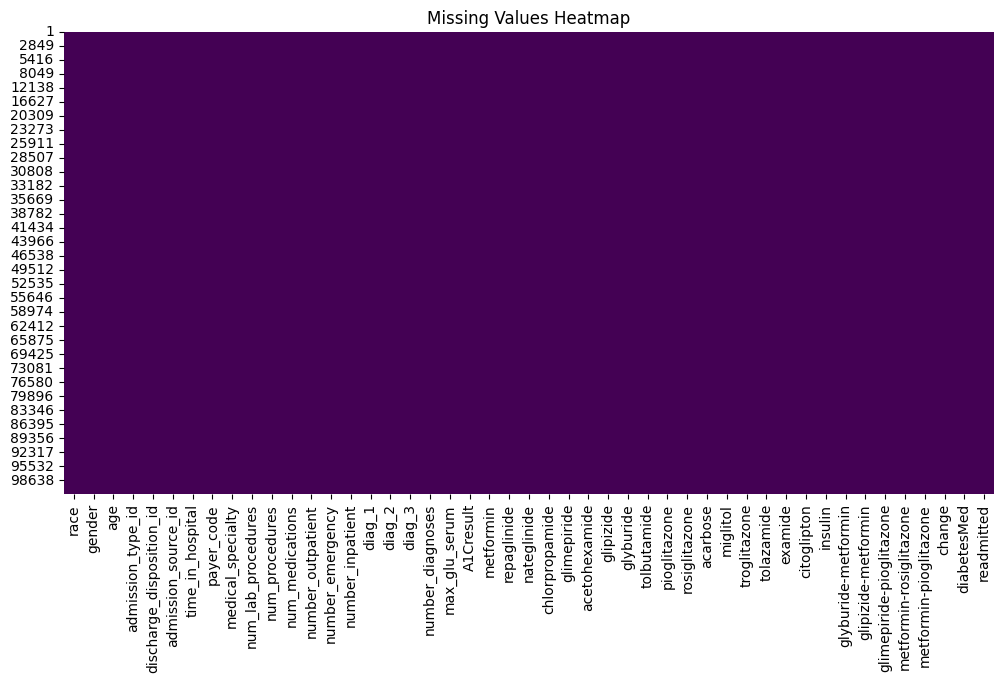

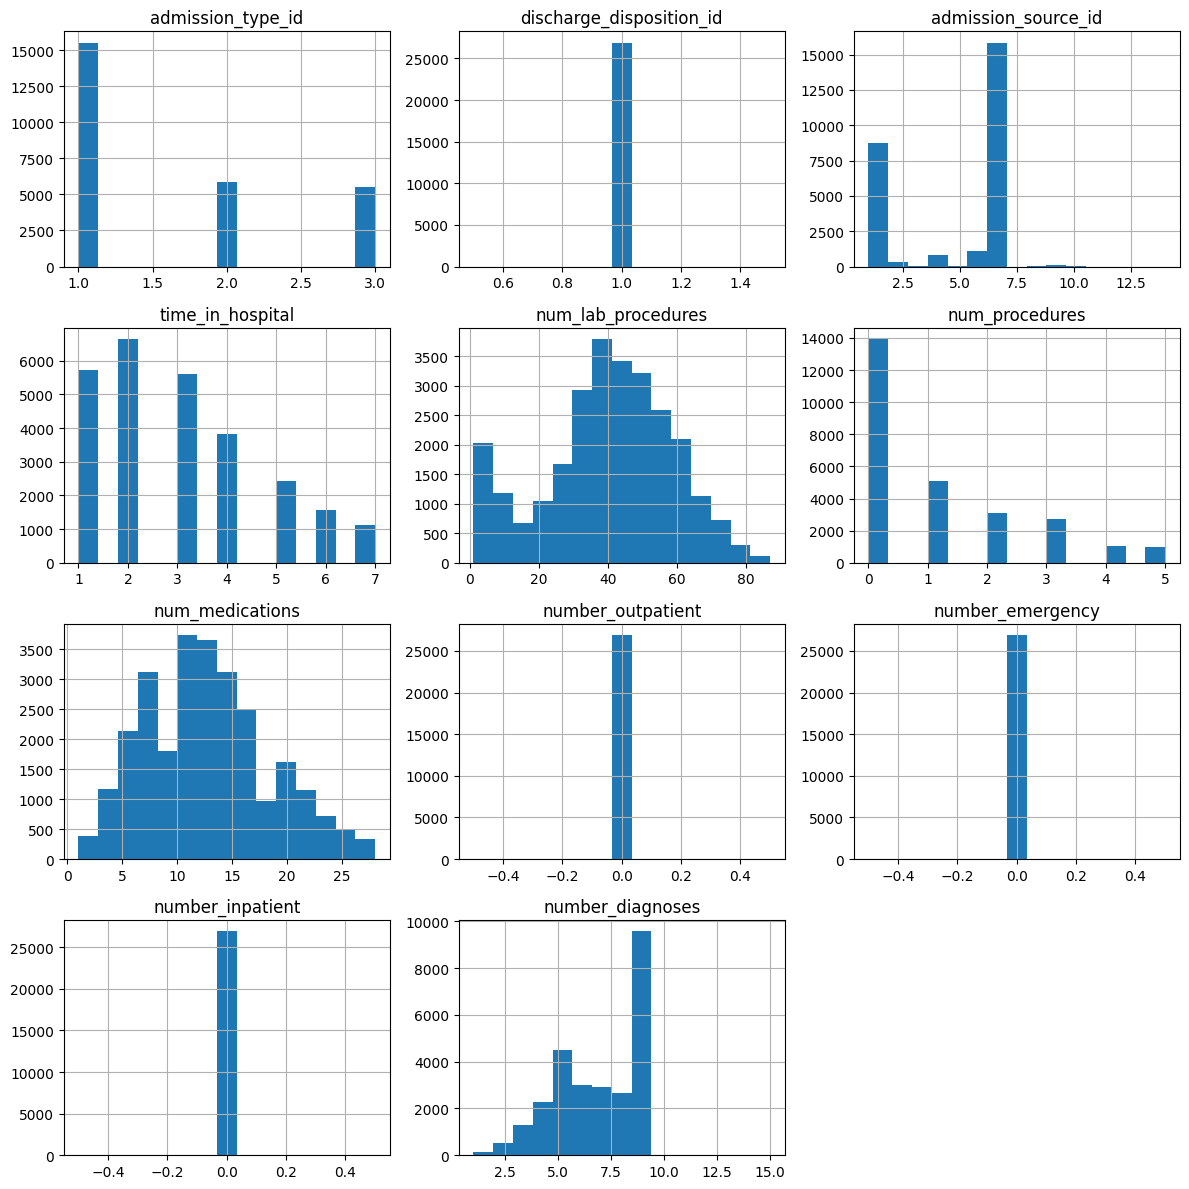


Final Data Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 26913 entries, 1 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      26913 non-null  object
 1   gender                    26913 non-null  object
 2   age                       26913 non-null  object
 3   admission_type_id         26913 non-null  int64 
 4   discharge_disposition_id  26913 non-null  int64 
 5   admission_source_id       26913 non-null  int64 
 6   time_in_hospital          26913 non-null  int64 
 7   payer_code                26913 non-null  object
 8   medical_specialty         26913 non-null  object
 9   num_lab_procedures        26913 non-null  int64 
 10  num_procedures            26913 non-null  int64 
 11  num_medications           26913 non-null  int64 
 12  number_outpatient         26913 non-null  int64 
 13  number_emergency          26913 non-null  int64 
 14  numb

In [92]:
# Display initial data information
print("Initial Data Information:")
print(data.info())

# Step 1: Drop irrelevant columns
# Example: Dropping columns that are not useful for analysis
irrelevant_columns = ['encounter_id', 'patient_nbr', 'weight']  # Include weight to drop
data.drop(columns=irrelevant_columns, inplace=True, errors='ignore')  # 'ignore' avoids error if column doesn't exist

# Display data after dropping irrelevant columns
print("\nData after dropping irrelevant columns:")
print(data.head())

# Step 2: Handle missing values (including replacing '?' with NaN)
data.replace('?', np.nan, inplace=True)  # Replace '?' with NaN

# Check for missing values before imputation
missing_before = data.isnull().sum()
print("\nMissing values before imputation:")
print(missing_before[missing_before > 0])  # Show only columns with missing values

# Impute missing categorical values with 'Unknown' or mode
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data[col].fillna('Unknown', inplace=True)

# Impute missing numerical values with the median
numerical_cols = data.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    data[col].fillna(data[col].median(), inplace=True)

# Check for missing values after imputation
missing_after = data.isnull().sum()
print("\nMissing values after imputation:")
print(missing_after[missing_after > 0])  # Show only columns with missing values

# Display data after handling missing values
print("\nData after handling missing values:")
print(data.head())

# Optional Step: Remove extreme outliers in numerical columns
def remove_outliers(df, column):
    # Calculate the IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Determine outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter the DataFrame
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to all numerical columns
for col in numerical_cols:
    data = remove_outliers(data, col)

# Display data after removing outliers
print("\nData after removing outliers:")
print(data.head())

# Step 3: Visualize data after each cleaning step
# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Visualizing distributions of numerical columns after cleaning
data[numerical_cols].hist(figsize=(12, 12), bins=15)
plt.tight_layout()
plt.show()

# Final data overview
print("\nFinal Data Overview:")
print(data.info())
print(data.describe())


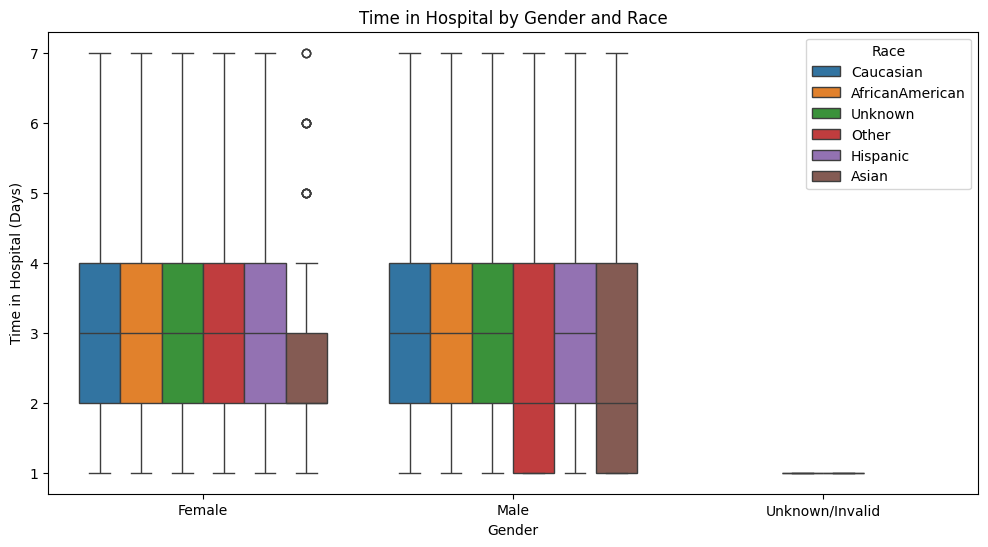

In [93]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Visualizing average time in hospital by gender and race
plt.figure(figsize=(12, 6))
sns.boxplot(x='gender', y='time_in_hospital', hue='race', data=data)
plt.title('Time in Hospital by Gender and Race')
plt.xlabel('Gender')
plt.ylabel('Time in Hospital (Days)')
plt.legend(title='Race')
plt.show()


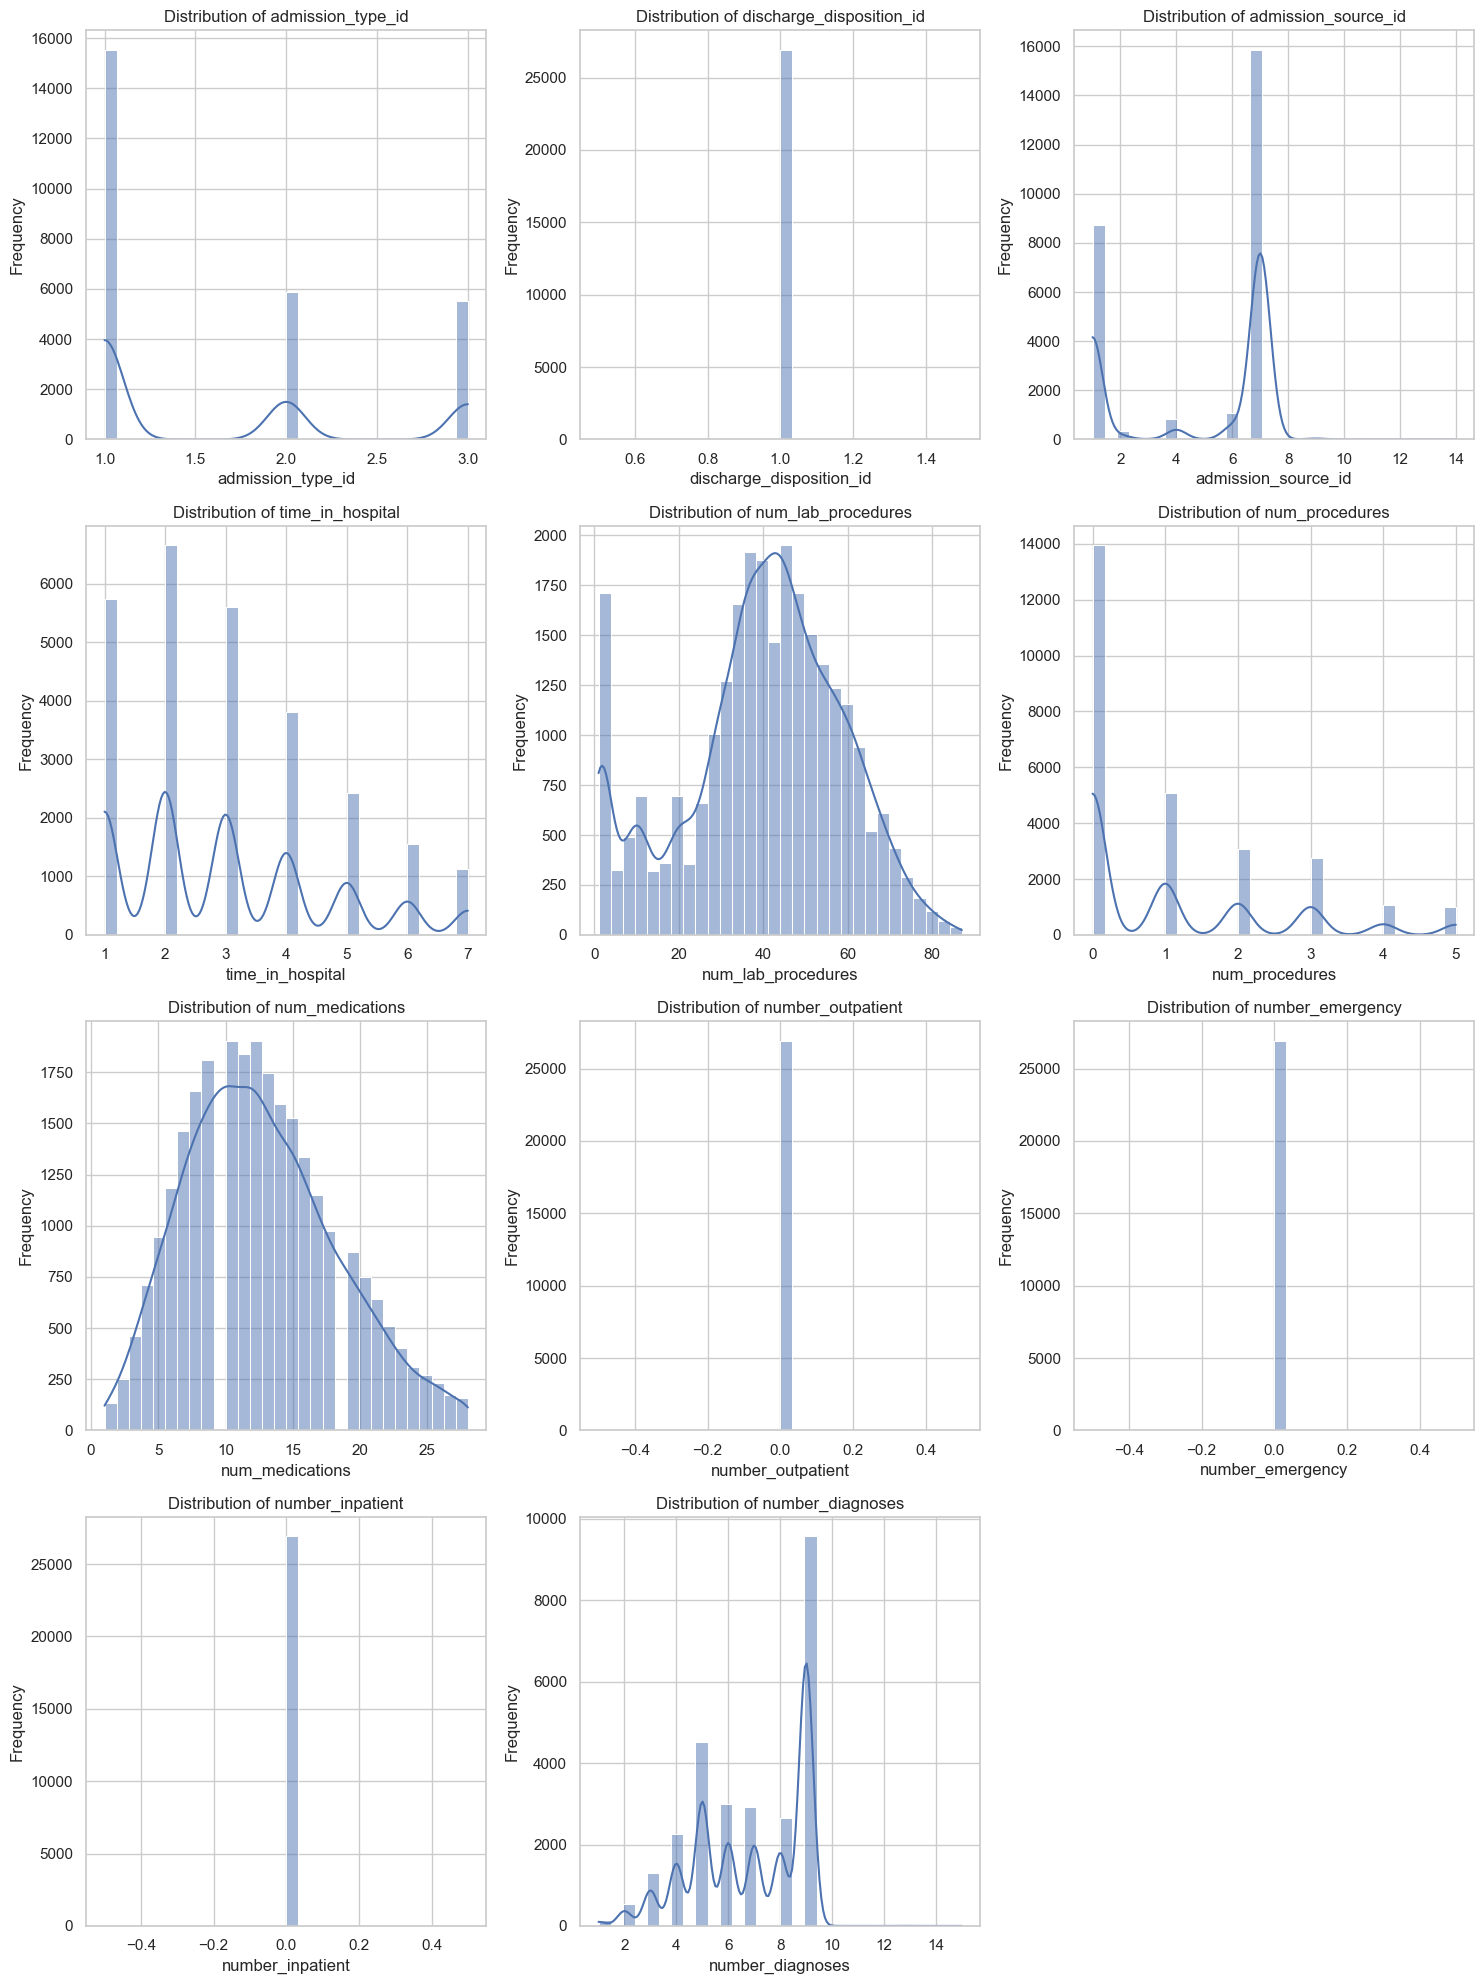

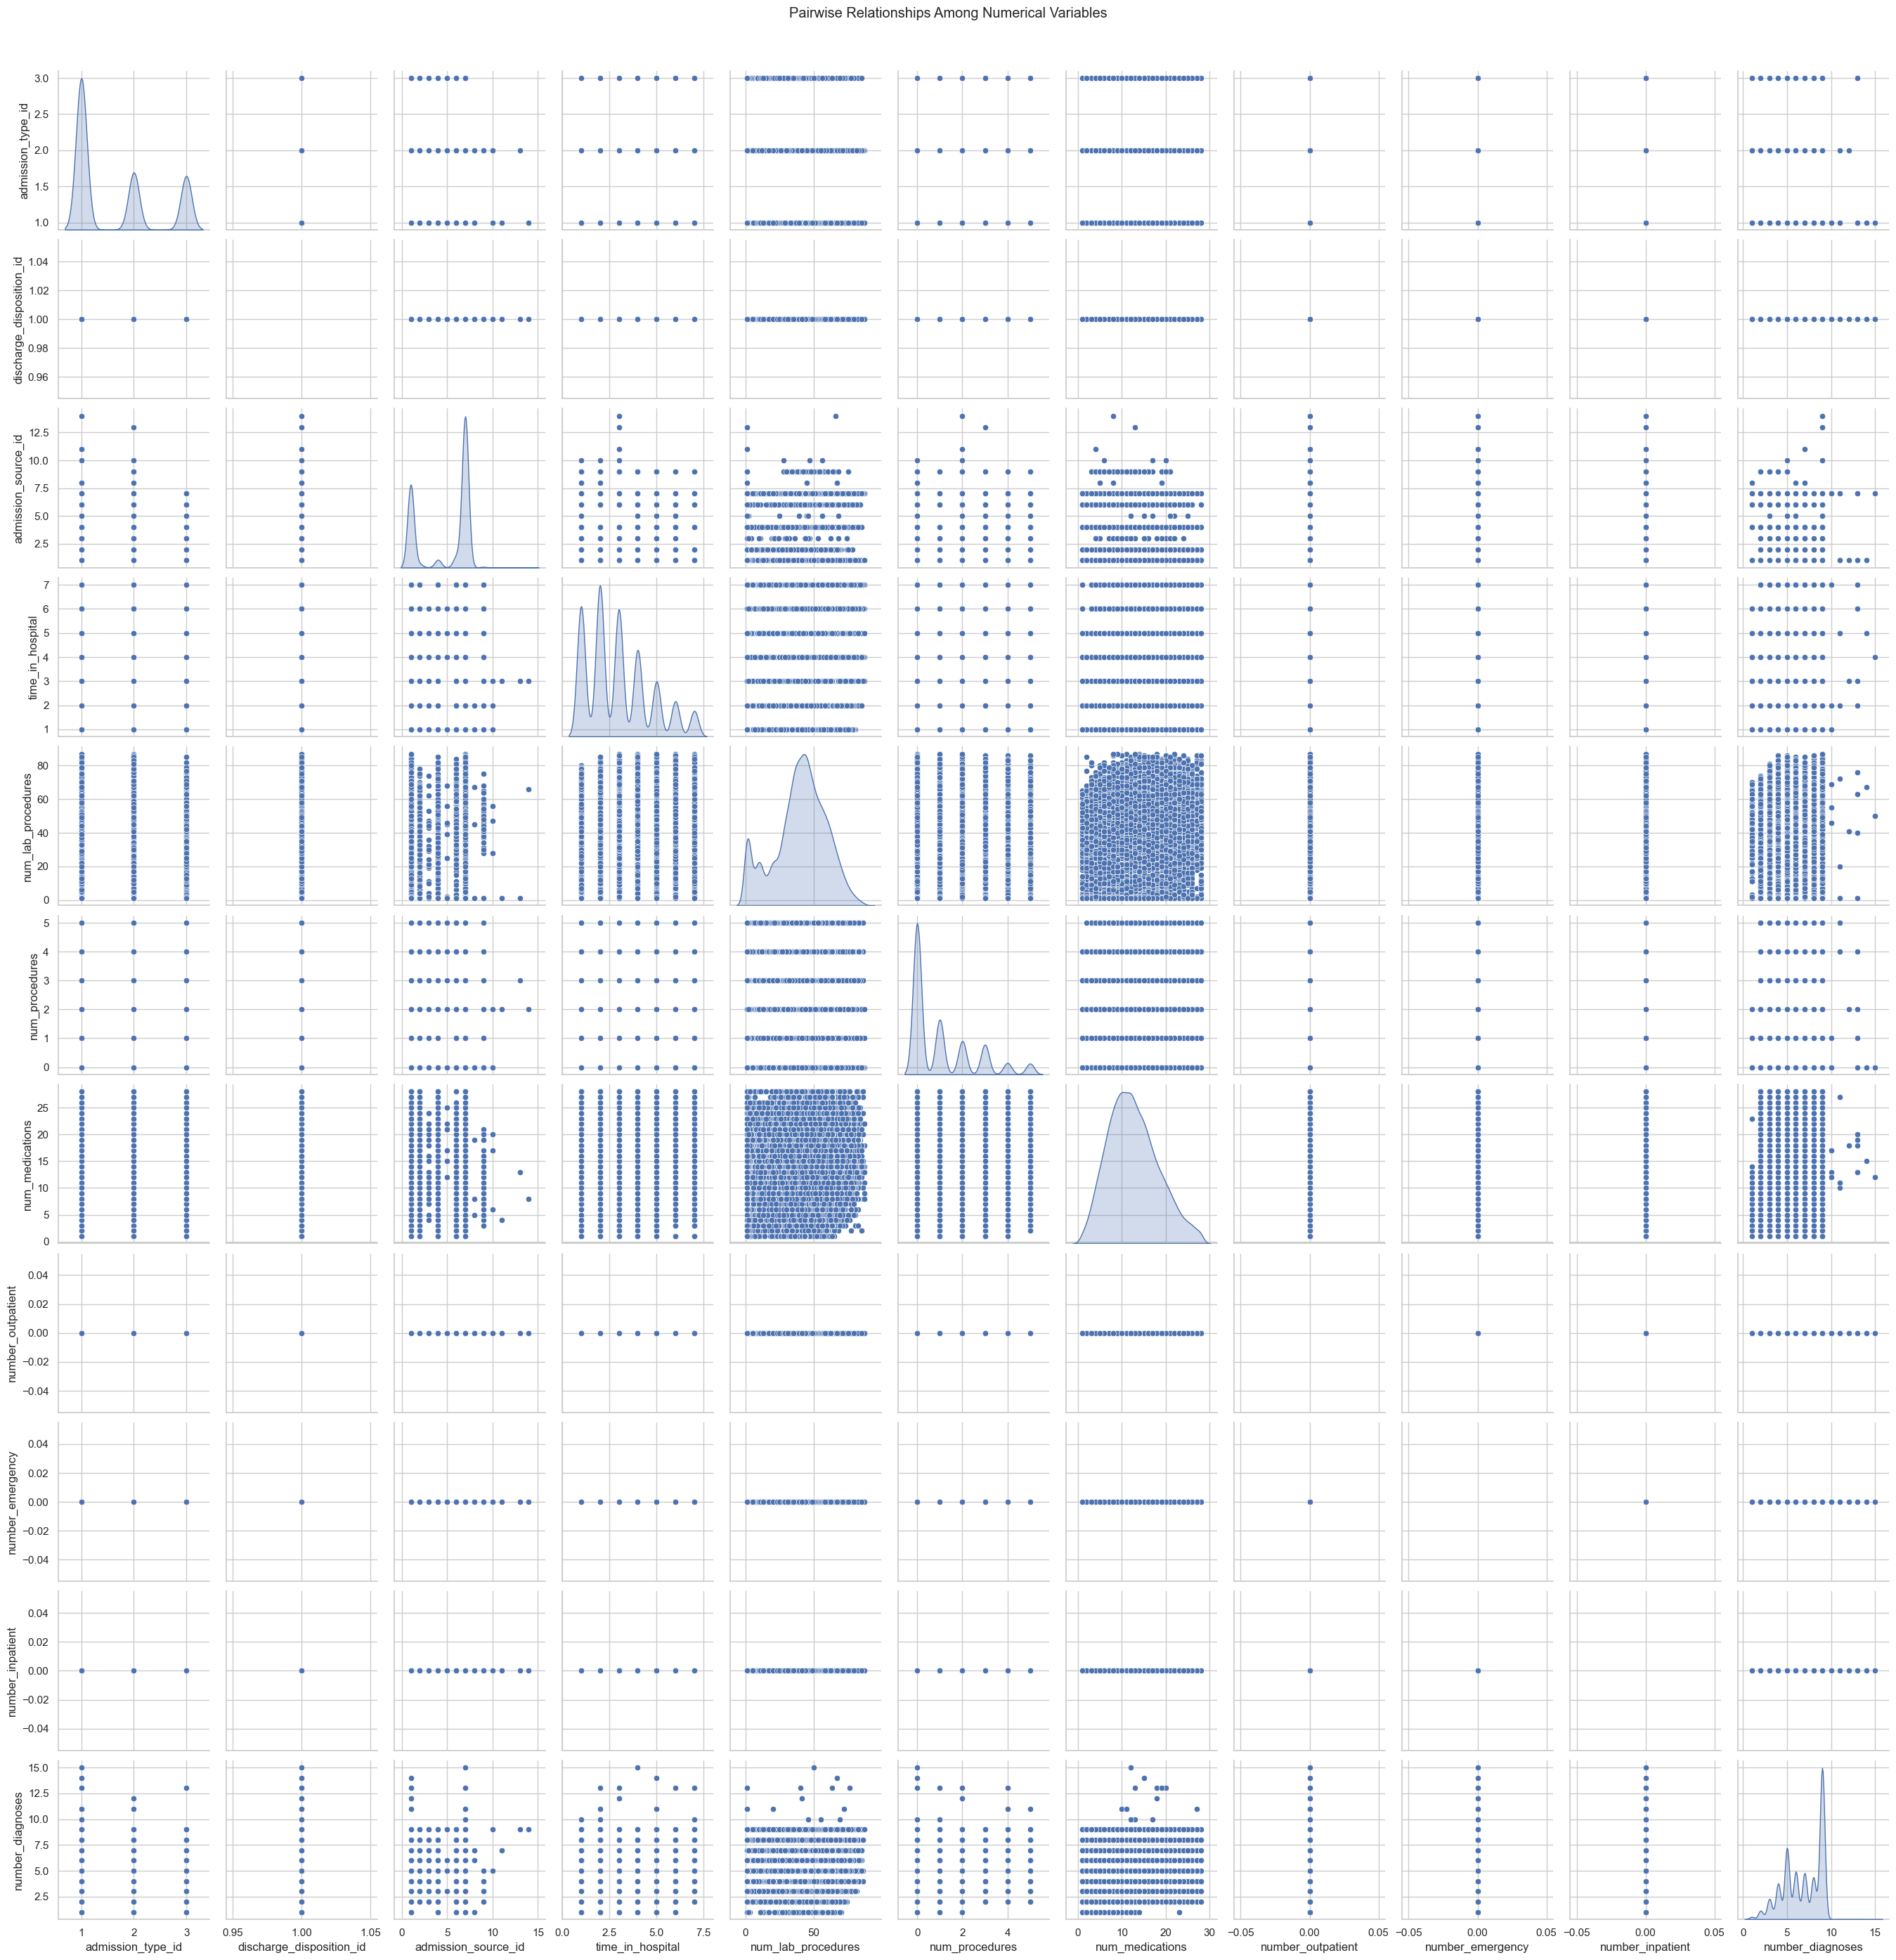

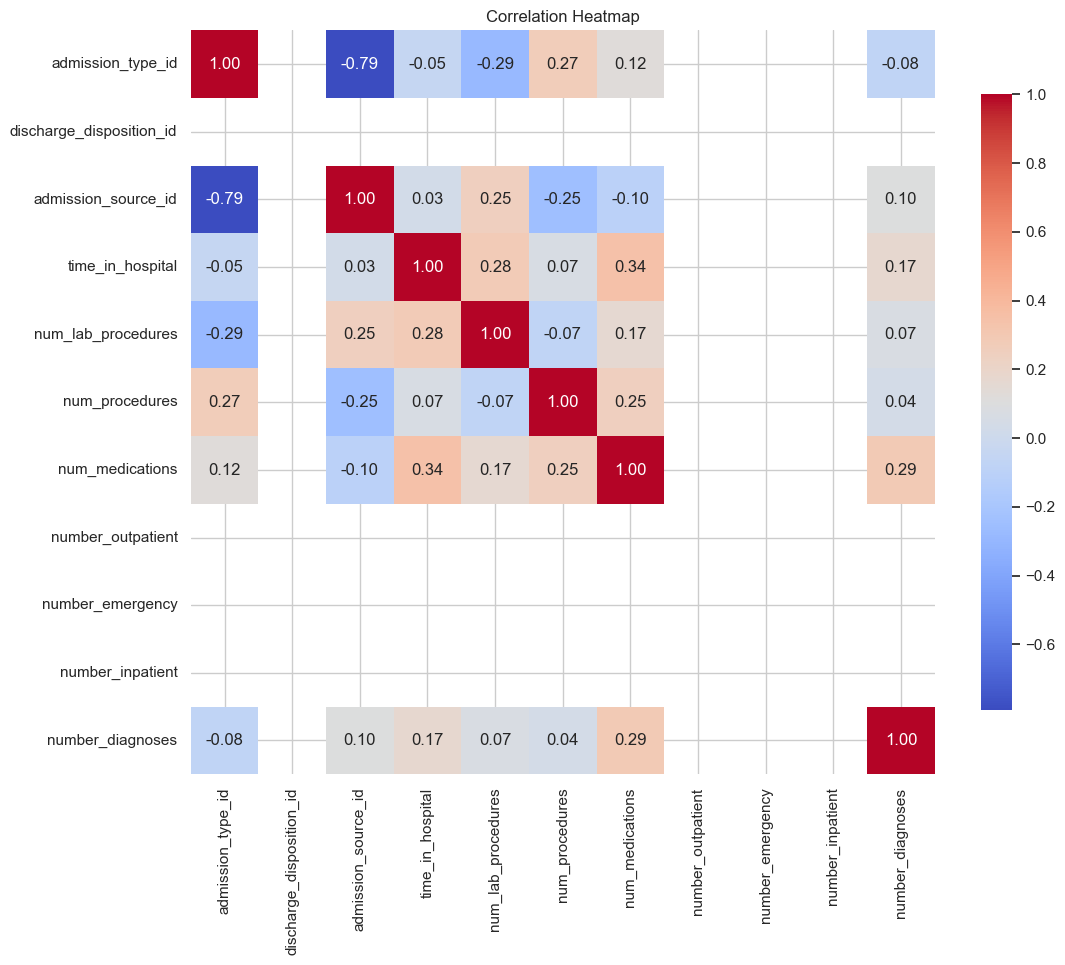

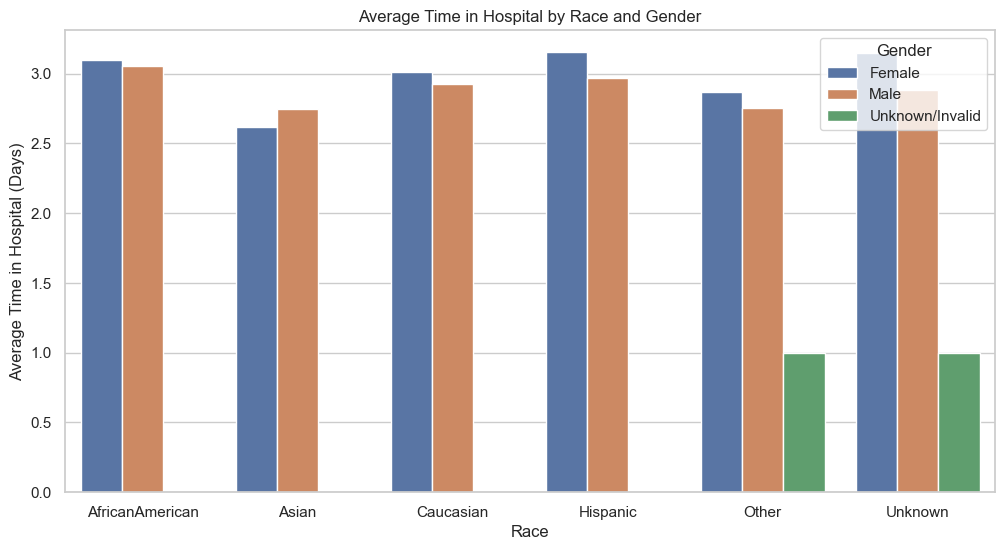

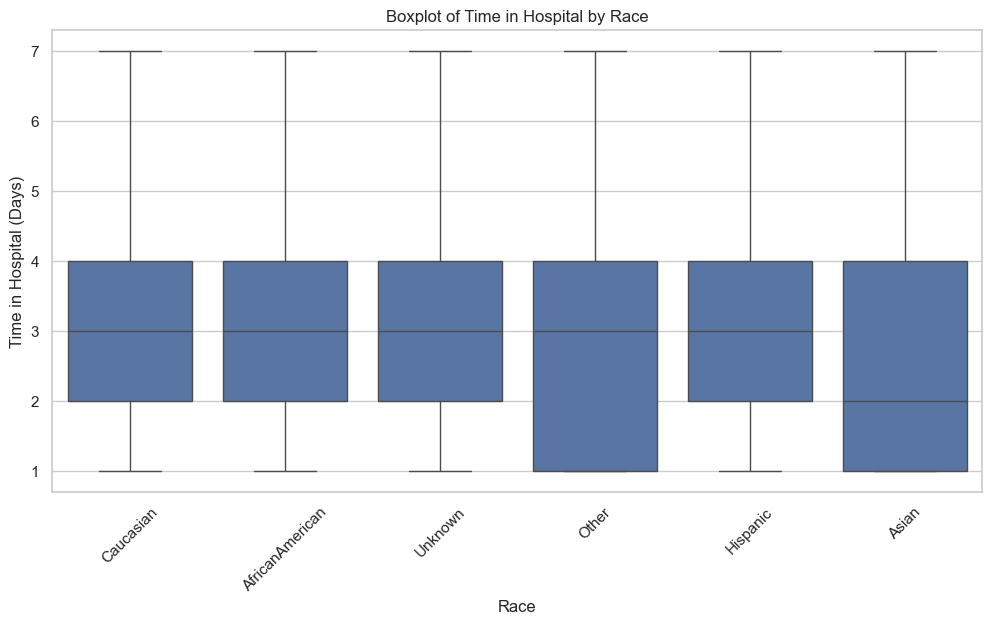

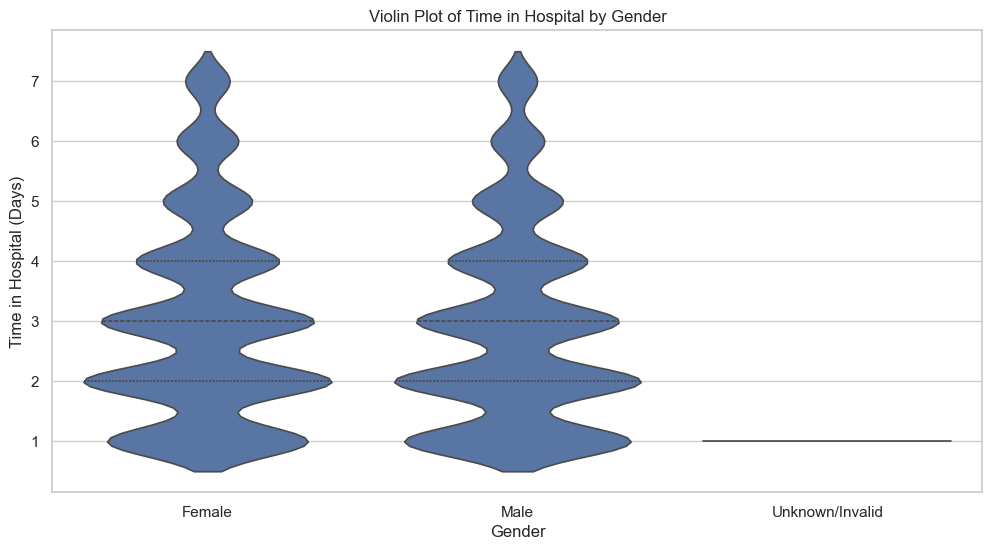

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Get the numerical columns
numerical_columns = data.select_dtypes(include=[np.number]).columns

# Calculate number of rows needed for subplots
num_cols = 3  # Number of columns in the subplot grid
num_rows = int(np.ceil(len(numerical_columns) / num_cols))  # Calculate number of rows

plt.figure(figsize=(15, 5 * num_rows))  # Adjust height based on number of rows
for i, column in enumerate(numerical_columns):
    plt.subplot(num_rows, num_cols, i + 1)  # Adjust the grid layout
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# Pair plot to visualize relationships between numerical variables
sns.pairplot(data[numerical_columns], diag_kind='kde')
plt.suptitle('Pairwise Relationships Among Numerical Variables', y=1.02)
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = data[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')
plt.show()


# Group by race and gender to compare average time in hospital
average_stay = data.groupby(['race', 'gender'])['time_in_hospital'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='race', y='time_in_hospital', hue='gender', data=average_stay)
plt.title('Average Time in Hospital by Race and Gender')
plt.xlabel('Race')
plt.ylabel('Average Time in Hospital (Days)')
plt.legend(title='Gender')
plt.show()


# Boxplot of time in hospital by race
plt.figure(figsize=(12, 6))
sns.boxplot(x='race', y='time_in_hospital', data=data)
plt.title('Boxplot of Time in Hospital by Race')
plt.xlabel('Race')
plt.ylabel('Time in Hospital (Days)')
plt.xticks(rotation=45)
plt.show()


# Violin plot for time in hospital by gender
plt.figure(figsize=(12, 6))
sns.violinplot(x='gender', y='time_in_hospital', data=data, inner="quartile")
plt.title('Violin Plot of Time in Hospital by Gender')
plt.xlabel('Gender')
plt.ylabel('Time in Hospital (Days)')
plt.show()


## First we run Unique Values: The unique values for each column that we suspect might be categorical

In [98]:
for column in diabetic_data.columns:
    print(f"{column}: {diabetic_data[column].unique()}")


encounter_id: ['2278392' '149190' '64410' ... '443854148' '443857166' '443867222']
patient_nbr: ['8222157' '55629189' '86047875' ... '140199494' '120975314' '175429310']
race: ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
gender: ['Female' 'Male' 'Unknown/Invalid']
age: [ 5. 15. 25. 35. 45. 55. 65. 75. 85. 95.]
admission_type_id: [6 1 2 3 4 5 8 7]
discharge_disposition_id: [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id: [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital: [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
medical_specialty: ['Pediatrics-Endocrinology' 'InternalMedicine' 'Family/GeneralPractice'
 'Cardiology' 'Surgery-General' 'Orthopedics' 'Gastroenterology'
 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Hematology/Oncolo

## 3.2 Encode Categorical Variables

Current columns in the DataFrame:
 ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'cluster', 'age_group']
Missing columns for one-hot encoding: ['payer_code']
Columns in the DataFrame after one-hot encoding:
 ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'admission_type_i

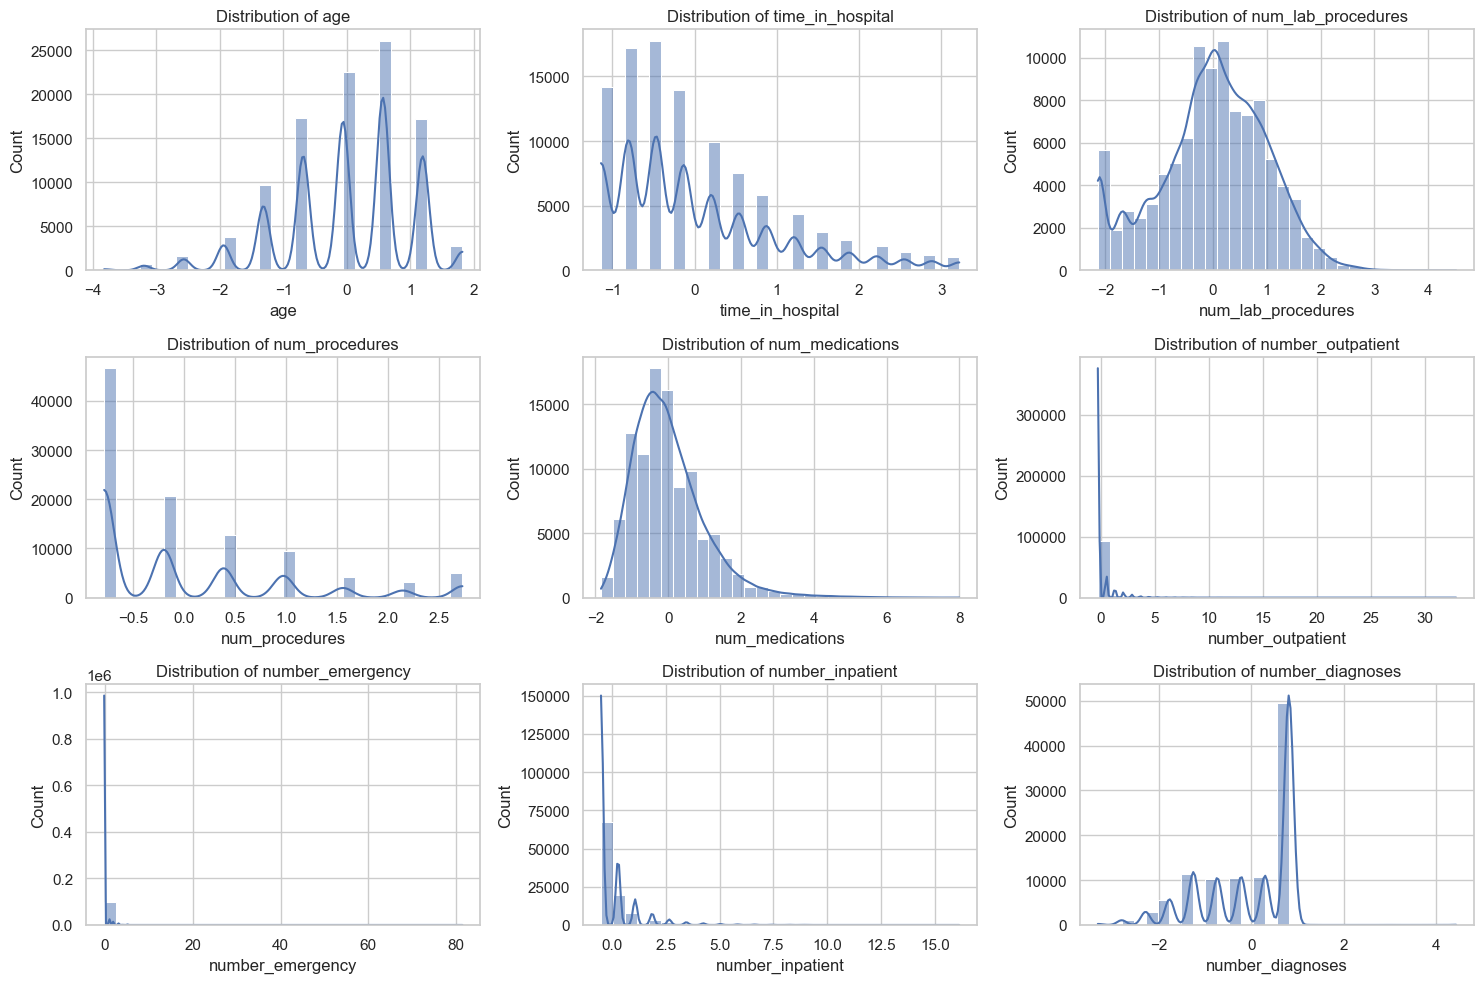

In [100]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Assuming diabetic_data is already defined and cleaned

# Step 1: Print the current columns to verify what exists
print("Current columns in the DataFrame:\n", diabetic_data.columns.tolist())

# Step 2: One-hot encoding for categorical variables
categorical_columns = ['race', 'gender', 'payer_code', 'medical_specialty', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'readmitted']

# Check which of the categorical columns are actually in the DataFrame
missing_columns = [col for col in categorical_columns if col not in diabetic_data.columns]
if missing_columns:
    print(f"Missing columns for one-hot encoding: {missing_columns}")
else:
    diabetic_data = pd.get_dummies(diabetic_data, columns=categorical_columns, drop_first=True)
    print("Encoded categorical columns into numeric format using one-hot encoding.")

# Print the columns again to confirm changes
print("Columns in the DataFrame after one-hot encoding:\n", diabetic_data.columns.tolist())

# Step 3: Create age groups if not present
if 'age_group' not in diabetic_data.columns:
    # Create age groups based on numerical 'age' column
    age_bins = [0, 30, 50, 70, 90, 100]
    age_labels = ['<30', '30-49', '50-69', '70-89', '90+']
    diabetic_data['age_group'] = pd.cut(diabetic_data['age'], bins=age_bins, labels=age_labels, right=False)
    print("Created 'age_group' from 'age' ranges.")

# Step 4: Label encoding for ordinal categorical variables
label_encoder = LabelEncoder()

# Encode 'age_group'
if 'age_group' in diabetic_data.columns:
    diabetic_data['age_group'] = label_encoder.fit_transform(diabetic_data['age_group'].astype(str))
else:
    print("'age_group' column is missing, unable to encode.")

print("***************************************************")
# Encode 'readmitted'
if 'readmitted' in diabetic_data.columns:
    diabetic_data['readmitted'] = label_encoder.fit_transform(diabetic_data['readmitted'])
else:
    print("'readmitted' column is missing, unable to encode.")

print("Encoded 'age_group' and 'readmitted' using label encoding.")

# Step 5: Scaling numerical features
numerical_columns = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                     'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

scaler = StandardScaler()
diabetic_data[numerical_columns] = scaler.fit_transform(diabetic_data[numerical_columns])
print("Scaled numerical features using StandardScaler.")

# Step 6: Final checks after modifications
print("Final Data Types:\n", diabetic_data.dtypes)
print("Final DataFrame Structure:\n")
print(diabetic_data.info())
print("\nPreview of the dataset:\n", diabetic_data.head())

# Optional: Visualize some distributions or transformed data
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing scaled numerical features
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)  # Adjust the grid layout as necessary
    sns.histplot(diabetic_data[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()


In [ ]:
#check for any missing values in our dataset
print(diabetic_data.isnull().sum())


encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazo

## 3.2.1 Check the data types again to ensure all transformations have been applied correctly

In [103]:
# CHECKPOINT 
# Drop the 'encounter_id' and 'patient_nbr' columns
diabetic_data = diabetic_data.drop(columns=['encounter_id', 'patient_nbr'])
# Check the structure of the DataFrame
print("Final DataFrame Structure:")
print(diabetic_data.info())

# Check descriptive statistics of the DataFrame
print("\nDescriptive Statistics:")
print(diabetic_data.describe(include='all'))

# Optionally, check for missing values
print("\nMissing Values Count:")
print(diabetic_data.isnull().sum())


Final DataFrame Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   race                      101766 non-null  object 
 1   gender                    101766 non-null  object 
 2   age                       101766 non-null  float64
 3   admission_type_id         101766 non-null  int64  
 4   discharge_disposition_id  101766 non-null  int64  
 5   admission_source_id       101766 non-null  int64  
 6   time_in_hospital          101766 non-null  float64
 7   medical_specialty         101766 non-null  object 
 8   num_lab_procedures        101766 non-null  float64
 9   num_procedures            101766 non-null  float64
 10  num_medications           101766 non-null  float64
 11  number_outpatient         101766 non-null  float64
 12  number_emergency          101766 non-null  float64
 13  number_inpatient 

# 3.2.2 Ensure that all categorical features are appropriately encoded
# Check for Multicollinearity:
# Feature Scaling

Unique values in 'race': ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
Unique values in 'gender': ['Female' 'Male' 'Unknown/Invalid']
Unique values in 'medical_specialty': ['Pediatrics-Endocrinology' 'InternalMedicine' 'Family/GeneralPractice'
 'Cardiology' 'Surgery-General' 'Orthopedics' 'Gastroenterology'
 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Hematology/Oncology'
 'Otolaryngology' 'Surgery-Colon&Rectal' 'Pediatrics-CriticalCare'
 'Endocrinology' 'Urology' 'Psychiatry-Child/Adolescent'
 'Pediatrics-Pulmonology' 'Neurology' 'Anesthesiology-Pediatric'
 'Radiology' 'Pediatrics-Hematology-Oncology' 'Psychology' 'Podiatry'
 'Gynecology' 'Oncology' 'Pediatrics-Neurology' 'Surgery-Plastic'
 'Surgery-Thoracic' 'Surgery-PlasticwithinHeadandNeck' 'Ophthalmology'
 'Surgery-Pediatric' 'Pediatrics-Emergen

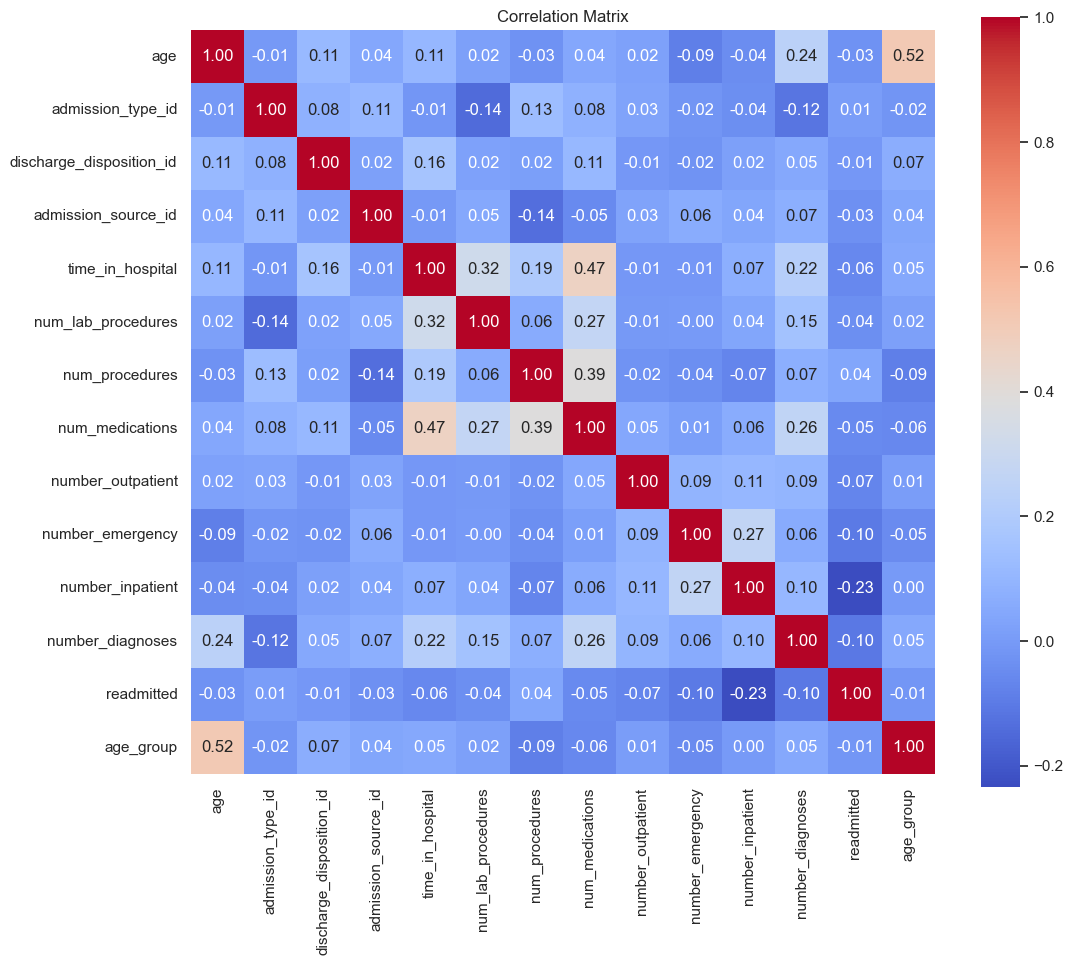

^***************************************************************


In [104]:
for col in diabetic_data.select_dtypes(include='object').columns:
    print(f"Unique values in '{col}': {diabetic_data[col].unique()}")
print("^***************************************************************")
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Calculate the correlation matrix on numeric columns only
numeric_data = diabetic_data.select_dtypes(include=['float64', 'int64'])  # Include float and int types
corr = numeric_data.corr()

# Step 2: Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

print("^***************************************************************")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
diabetic_data[['age']] = scaler.fit_transform(diabetic_data[['age']])



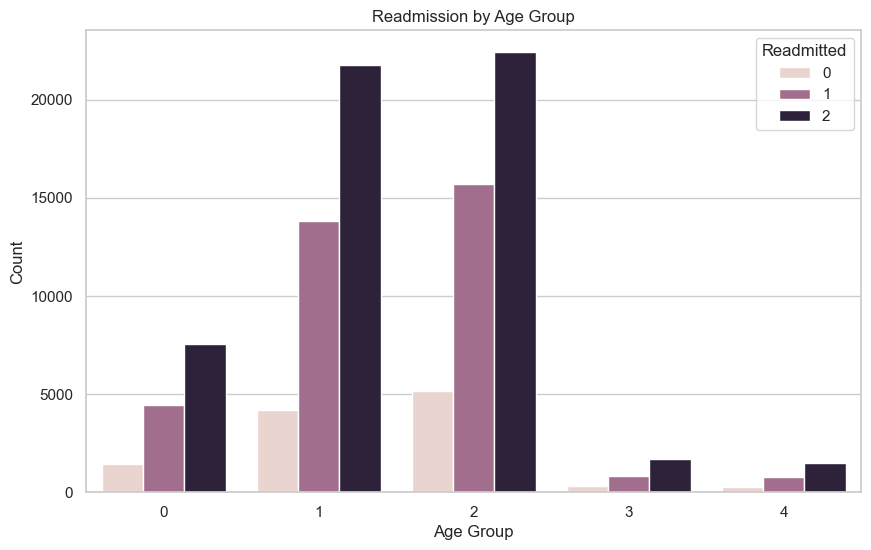

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count plot for readmission by age group
plt.figure(figsize=(10, 6))
sns.countplot(data=diabetic_data, x='age_group', hue='readmitted')
plt.title('Readmission by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Readmitted', loc='upper right')
plt.show()


## Step 4: Train-Test Split 

In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming diabetic_data is your cleaned and processed DataFrame

# Step 1: Print current columns to verify what's available
print("Current columns in the DataFrame:\n", diabetic_data.columns.tolist())

# Step 2: Define the feature matrix X and the target variable Y
# Features: All columns except for the target and identifiers
# Adjust this list based on the available columns
columns_to_drop = ['readmitted']  # Start with the target variable
optional_drop_columns = ['encounter_id', 'patient_nbr']  # Only drop if they exist

# Check if columns to drop exist and update accordingly
for col in optional_drop_columns:
    if col in diabetic_data.columns:
        columns_to_drop.append(col)

# Now, create the feature matrix and target variable
X = diabetic_data.drop(columns=columns_to_drop)
Y = diabetic_data['readmitted']  # This should be your target variable

# Step 3: Perform the train-test split (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Output the shapes of the resulting datasets to confirm the split
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")


Current columns in the DataFrame:
 ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'cluster', 'age_group']
X_train shape: (81412, 45)
X_test shape: (20354, 45)
Y_train shape: (81412,)
Y_test shape: (20354,)
